# Tobigs 15기 Week7 NN 심화 - 15기 이성범

In [1]:
# 패키기 불러오기
import sys
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D

In [2]:
# 재현가능성을 위한 seed 고정
def seed_everything(seed = 22):
  random.seed(seed)
  np.random.seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)

  # torch 용
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)  # type: ignore
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True  # type: ignore
  torch.backends.cudnn.benchmark = True  # type: ignore

  # tensorflow 용
  tf.random.set_seed(seed)

seed_everything()

In [3]:
paths = '/content/drive/MyDrive/Tobigs/'
train = pd.read_csv(paths + 'train.csv')
test = pd.read_csv(paths + 'test.csv')
submission = pd.read_csv(paths + 'sample_submission.csv')

# 데이터 확인

<Figure size 432x288 with 0 Axes>

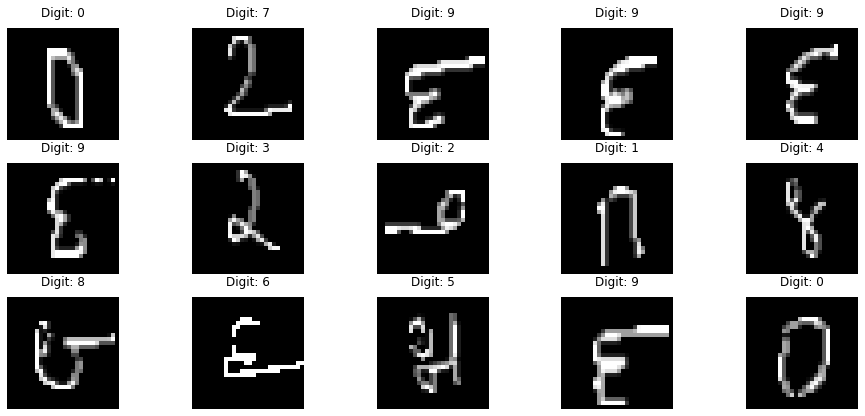

In [4]:
# data를 각 픽셀에 이름붙여 표현
feat_cols = ['pixel'+str(i) for i in range(784)]

# 무작위로 섞음
rndperm = np.random.permutation(train.shape[0])

# 15개의 데이터만 시각화 함
plt.gray()
fig = plt.figure(figsize=(16, 7))
for i in range(0,15):
    ax = fig.add_subplot(3, 5, i+1, title="Digit: {}".format(str(train.loc[rndperm[i],'label'])) )
    ax.matshow(train.loc[rndperm[i],feat_cols].values.reshape((28,28)).astype(float))
    ax.axis('off')
plt.show()

캐나다 원주민 글씨 데이터 셋이기 때문에 처음보는 알파벳이 많이 존재함

In [5]:
# 딥러닝을 위한 데이터로 변환 후 정규화를 진행

X = train.drop('label',axis = 1).values.astype('float32') / 255.
y = train['label'].values

test = test.iloc[:,1:].values.astype('float32') / 255.

# Pytorch

## ResNet을 활용

ResNet은 ILSVRC 대회에서 2015년에 우승한 모델로 지금 까지도 이미지 분류의 기본 모델로 널리 활용되고 있기 때문에 기본 ResNet을 가지고 이미지 분류를 함

In [6]:
# 구글 코랩을 통해서 GPU를 이용한 학습을 함

if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print(DEVICE)

cuda


## 데이터 전처리를 위한 함수 정의

In [8]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):

  # 데이터 정의
  def __init__(self, x_data, y_data = None, img_rows = 28, img_cols = 28):
    self.x_data = x_data.reshape(x_data.shape[0], 1, img_rows, img_cols)
    self.y_data = y_data

  # 이 데이터 셋의 총 데이터 수
  def __len__(self):
    return len(self.x_data)

  # 어떠한 idx를 받았을 때 그에 맞는 데이터를 반환
  def __getitem__(self, idx):
    if self.y_data is None:
      x = torch.FloatTensor(self.x_data[idx])
      return x
    else:
      x = torch.FloatTensor(self.x_data[idx])
      y = torch.LongTensor(self.y_data.reshape(-1,1)[idx])[0]
      return x, y

In [10]:
dataset = CustomDataset(x_data = X, y_data = y)

dataloader = DataLoader(
    dataset,
    batch_size = BATCH_SIZE,
    shuffle = True
)

for (X_train, y_train) in dataloader:
  print(X_train.size())
  print(y_train.size())
  break

torch.Size([128, 1, 28, 28])
torch.Size([128])


학습시에 활용되는 데이터 확인 1채널로된 이미지 데이터라는 것을 알 수 있음

## 모델 정의

https://www.kaggle.com/tonysun94/pytorch-1-0-1-on-mnist-acc-99-8

In [12]:
from torchvision.models.resnet import ResNet, BasicBlock

class MNISTResNet(ResNet):
  def __init__(self):
    # 데이터 구성에 알맞게 채널과 분류 데이터의 개수를 변환
    # Conv2d에서 1채널로 변환, __init__에서 num_classes를 10개로 변환
    super(MNISTResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes = 10)
    self.conv1 = nn.Conv2d(1, 64, kernel_size = 7, stride = 1, padding = 1, bias = False)

In [18]:
model = MNISTResNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
costfuc = nn.CrossEntropyLoss()

print(model)

MNISTResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tru

## 모델 훈련 시에 활용되는 함수 정의

In [13]:
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = costfuc(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
        epoch, batch_idx * len(image), 
        len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
        loss.item()))

## 모델 평가 시에 활용되는 함수 정의

In [14]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += costfuc(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

## oof 기반의 모델 훈련

In [15]:
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm_notebook

# CV는 5로
n_split = 5

# 균등하게 니눌때 사용
skf = StratifiedKFold(n_splits = n_split, shuffle=True, random_state=22)


BATCH_SIZE = 128
EPOCHS = 50
img_rows = 28
img_cols = 28
num_classes = 10

train_oof = np.zeros_like(y)
test_oof = np.zeros((test.shape[0], num_classes))

test_dataset = CustomDataset(test)

test_dataloader = DataLoader(
    test_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False)

cnt = 1

for trn_idx, val_idx in tqdm_notebook(skf.split(X, y)):
  trn_data, trn_label = X[trn_idx], y[trn_idx]
  val_data, val_label = X[val_idx], y[val_idx]

  train_dataset = CustomDataset(trn_data, trn_label)
  val_dataset = CustomDataset(val_data, val_label)
  test_dataset = CustomDataset(test)

  train_dataloader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True)
  
  val_dataloader = DataLoader(
    val_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False)
  
  print(f'---------------------------------{cnt}번째 oof 시작-------------------------------')

  model = MNISTResNet().to(DEVICE)
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
  costfuc = nn.CrossEntropyLoss()

  for epoch in range(1, EPOCHS + 1):
    train(model, train_dataloader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, val_dataloader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))
  
  model.eval()
  test_preds = []
  val_preds = []

  with torch.no_grad():

    for inputs in test_dataloader:
      test_preds.append(model(inputs.cuda()).cpu().numpy())

    for inputs, targets in val_dataloader:
      val_preds.append(model(inputs.cuda()).cpu().numpy().argmax(axis=1))

  train_oof[val_idx] = np.concatenate(val_preds)

  test_oof += np.concatenate(test_preds) / n_split

  print(f'---------------------------------{cnt}번째 oof 종료-------------------------------')
  cnt += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


---------------------------------1번째 oof 시작-------------------------------
Train Epoch: 1 [0/33600 (0%)]	Train Loss: 2.414849
Train Epoch: 1 [25600/33600 (76%)]	Train Loss: 0.095461

[EPOCH: 1], 	Test Loss: 0.0003, 	Test Accuracy: 98.63 % 

Train Epoch: 2 [0/33600 (0%)]	Train Loss: 0.014635
Train Epoch: 2 [25600/33600 (76%)]	Train Loss: 0.041512

[EPOCH: 2], 	Test Loss: 0.0003, 	Test Accuracy: 98.80 % 

Train Epoch: 3 [0/33600 (0%)]	Train Loss: 0.004584
Train Epoch: 3 [25600/33600 (76%)]	Train Loss: 0.117217

[EPOCH: 3], 	Test Loss: 0.0002, 	Test Accuracy: 99.12 % 

Train Epoch: 4 [0/33600 (0%)]	Train Loss: 0.006167
Train Epoch: 4 [25600/33600 (76%)]	Train Loss: 0.019936

[EPOCH: 4], 	Test Loss: 0.0003, 	Test Accuracy: 99.12 % 

Train Epoch: 5 [0/33600 (0%)]	Train Loss: 0.005444
Train Epoch: 5 [25600/33600 (76%)]	Train Loss: 0.022973

[EPOCH: 5], 	Test Loss: 0.0005, 	Test Accuracy: 98.36 % 

Train Epoch: 6 [0/33600 (0%)]	Train Loss: 0.020935
Train Epoch: 6 [25600/33600 (76%)]	Train Los

In [16]:
from sklearn.metrics import accuracy_score

print('Train accuracy_score: ', accuracy_score(train_oof, y))

Train accuracy_score:  0.9958095238095238


In [17]:
test_pred_labels = np.argmax(test_oof, axis=1)

submission['Category'] = test_pred_labels
submission.to_csv("ResNet_oof.csv",index=False)
submission.head()

,Id,Category
0,57808,8
1,4960,0
2,35755,5
3,15543,3
4,48968,8


Train Set: 0.99580

Test Set: 0.99711

더 많은 학습을 하면 좋지만 Colab을 사용하기 때문에 메모리와 시간상의 부족으로 50번만 학습했습니다. 만약 학습량을 더 늘린다면 모델의 성능도 더 높아질 것 입니다. 또한 아직 CNN에 대한 지식이 부족해서 더 나은 성능의 모델을 구성하지 못했습니다.


# keras 

oof 기반의 전이학습 방식의 모델을 활용 

1, 2, 3, 4, 5 <- 총 데이터 셋

## oof 1번째

model -> 학습이 진행되지 않은 상태

[2,3,4,5] ->  학습

[1] -> 평가

## oof 2번째

model -> oof 첫번째에 학습된 모델

[1,3,4,5] ->  학습

[2] -> 평가

## ....

위와 같은 방식으로 순차적으로 학습

## 데이터 전처리를 위한 함수 정의

In [19]:
def preprocesing(x_trn_data, x_val_data, y_trn_data, y_val_data):

  img_rows = 28
  img_cols = 28

  x_train = x_trn_data.reshape(x_trn_data.shape[0], img_rows, img_cols, 1)
  x_test = x_val_data.reshape(x_val_data.shape[0], img_rows, img_cols, 1)

  # 예측 데이터는 0~9까지 총 10개
  num_classes = 10

  # 예측 데이터를 범주화 시킴
  y_train = keras.utils.to_categorical(y_trn_data, num_classes)
  y_test = keras.utils.to_categorical(y_val_data, num_classes)

  return x_train, x_test, y_train, y_test

## 모델 정의

Convolution Layer, BatchNormalization, Dropout 으로만 구성된 모델

https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist

In [20]:
img_rows = 28
img_cols = 28

input_shape = (img_rows, img_cols, 1)

batch_size = 64

# 예측 데이터는 0~9까지 총 10개
num_classes = 10

# 30번 학습
epochs = 30

In [21]:
model = Sequential()

model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = input_shape))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size = 4, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0

## oof 기반의 모델 훈련

In [22]:
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm_notebook

# CV는 5로
n_split = 5

# 균등하게 니눌때 사용
skf = StratifiedKFold(n_splits = n_split, shuffle=True, random_state=22)

x_test = test.reshape(test.shape[0], img_rows, img_cols, 1)

train_oof = np.zeros_like(y)

test_oof = np.zeros((x_test.shape[0], num_classes))

cnt = 1

for trn_idx, val_idx in tqdm_notebook(skf.split(X, y)):
  trn_data, trn_label = X[trn_idx], y[trn_idx]
  val_data, val_label = X[val_idx], y[val_idx]

  print(f'---------------------------------{cnt}번째 oof 시작-------------------------------')

  trn_data, val_data, trn_label, val_label = preprocesing(trn_data, val_data, trn_label, val_label)

  hist = model.fit(trn_data, trn_label, 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   verbose=1, 
                   validation_data=(val_data, val_label))
  
  val_pred = model.predict(val_data)

  val_pred_labels = np.argmax(val_pred, axis=1)

  train_oof[val_idx] = val_pred_labels

  pred = model.predict(x_test)

  test_oof += pred / n_split

  print(f'---------------------------------{cnt}번째 oof 종료-------------------------------')
  cnt += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


---------------------------------1번째 oof 시작-------------------------------
Epoch 1/30
525/525 [==============================] - 38s 9ms/step - loss: 0.5162 - accuracy: 0.8416 - val_loss: 0.0736 - val_accuracy: 0.9781
Epoch 2/30
525/525 [==============================] - 4s 8ms/step - loss: 0.0577 - accuracy: 0.9834 - val_loss: 0.0322 - val_accuracy: 0.9896
Epoch 3/30
525/525 [==============================] - 4s 8ms/step - loss: 0.0449 - accuracy: 0.9865 - val_loss: 0.0324 - val_accuracy: 0.9910
Epoch 4/30
525/525 [==============================] - 4s 8ms/step - loss: 0.0291 - accuracy: 0.9912 - val_loss: 0.0310 - val_accuracy: 0.9920
Epoch 5/30
525/525 [==============================] - 4s 8ms/step - loss: 0.0252 - accuracy: 0.9920 - val_loss: 0.0205 - val_accuracy: 0.9943
Epoch 6/30
525/525 [==============================] - 4s 8ms/step - loss: 0.0223 - accuracy: 0.9931 - val_loss: 0.0203 - val_accuracy: 0.9937
Epoch 7/30
525/525 [==============================] - 4s 8ms/step - loss

In [23]:
from sklearn.metrics import accuracy_score

print('Train accuracy_score: ', accuracy_score(train_oof, y))

Train accuracy_score:  0.9983571428571428


In [24]:
test_pred_labels = np.argmax(test_oof, axis=1)

submission['Category'] = test_pred_labels
submission.to_csv("CNN_oof.csv",index=False)
submission.head()

,Id,Category
0,57808,8
1,4960,0
2,35755,5
3,15543,3
4,48968,8


Train Set: 0.99883

Test Set: 0.99722

전이학습 느낌으로 모델을 학습 시킨 것이기때문에 모델은 총 150번의 학습을 했습니다. 모델의 구성을 다르게 한다면 더 나은 성능을 보여줄 가능성이 존재합니다.

keras는 seed를 고정하여도 학습 재현이 안되기 때문에 Pytorch를 사용하는 것이 더 좋을 듯 합니다.